# Nested Operator Inference

**TODO:** Add description
**TODO:** Why consider nested OpInf?
- start from smaller space
- way to update ROM

[1] Aretz, Nicole, and Karen Willcox. "Enforcing structure in data-driven reduced modeling through nested Operator Inference." In 2024 IEEE 63rd Conference on Decision and Control (CDC), pp. 8046-8053. IEEE, 2024.

[2] Aretz, Nicole, and Karen Willcox. "Nested Operator Inference for Adaptive Data-Driven Learning of Reduced-order Models." arXiv preprint arXiv:2508.11542 (2025).

[3] Qian, Elizabeth, Ionut-Gabriel Farcas, and Karen Willcox. "Reduced operator inference for nonlinear partial differential equations." SIAM Journal on Scientific Computing 44, no. 4 (2022): A1934-A1959.


## Problem Statement

We consider the cubic example from [2], section 5.1: For a heat conduction parameter $\kappa \in [0.001, 0.1]$, identiy $x(t,z)$ with
$$\dot{x}(t, z) = \kappa \Delta_z x(t, z) - x(t, z)^3, \qquad \forall t > 0, z \in (0, 1)$$
with initial condition $x(0, z) = 10z(1-z)$ and zero-Dirichlet boundary conditions $x(t, 0) = x(t, 1) = 0$ for all $t>0$. 

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.linalg as la
import time

import opinf

## Full-order model data
The problem is discretized using linear finite elements, and solved with Crank-Nicholson time-stepping using a step size of $\Delta t = 0.001$. 

The training and testing data used in [2] can be downloaded here. After the download, change the `path_to_data` variable below to where the data was saved.

In [2]:
path_to_data = "/storage/nicole/git-save-data/opinf/cubic-heat/paper/data/"

We load the whole data set for testing purposes.

In [3]:
# load in training and testing data
with open(path_to_data + "trainingdata", "rb") as file:
    Xi_test, U_para_test, compute_time = pickle.load(file)

nFE = U_para_test[0].shape[0] # finite element dimension
grid_t = np.arange(0, 1+0.001, 0.001) # temporal discretization
K_test = grid_t.shape[0]

The parameter $\kappa$ does SOMETHING.

<>:13: SyntaxWarning: invalid escape sequence '\k'
<>:13: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_832077/2601560414.py:13: SyntaxWarning: invalid escape sequence '\k'
  ax.set_title(f"full-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")


Text(0.5, 1.0, 'full-order solution, $\\kappa =0.01000$')

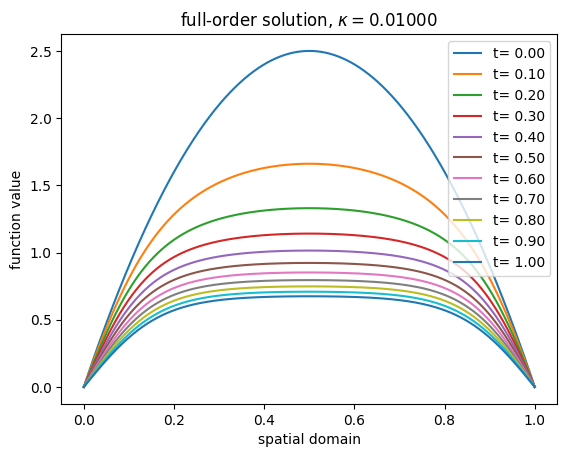

In [4]:
 # user input, choose between 0 and 200 (inclusive)
index_test = 100

# figure for how the parameter changes the FOM solution
fig, ax = plt.subplots(1, 1)

for k in range(0, K_test, 100):
    ax.plot(np.linspace(0, 1, nFE), U_para_test[index_test][:, k], label = f"t= {grid_t[k]:.2f}")

ax.legend()
ax.set_xlabel("spatial domain")
ax.set_ylabel("function value")
ax.set_title(f"full-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")

<>:8: SyntaxWarning: invalid escape sequence '\k'
<>:8: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_832077/1800324093.py:8: SyntaxWarning: invalid escape sequence '\k'
  axs[i].set_title(f"full-order solution, $\kappa ={Xi_test[index_test, 0]:.3f}$")


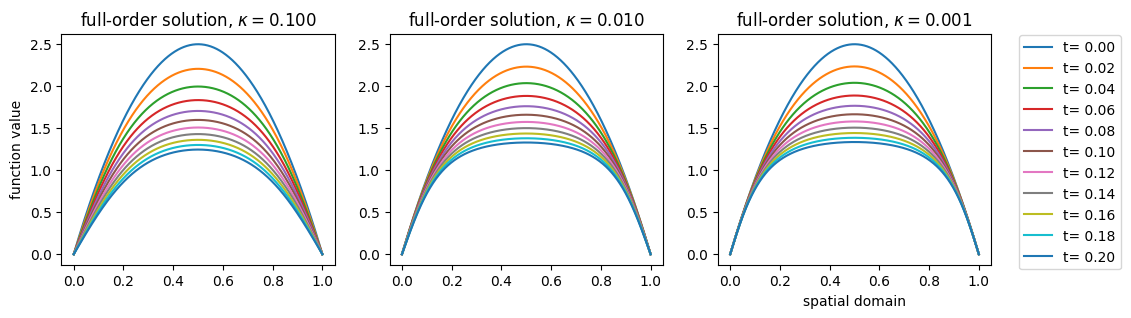

In [ ]:
# figure for how the parameter changes the FOM solution
fig, axs = plt.subplots(1, 3, figsize = (12, 3))

for i, index_test in enumerate([200, 100, 0]):
    for k in range(0, K_train, 20):
        axs[i].plot(np.linspace(0, 1, nFE), U_para_test[index_test][:, k], label = f"t= {grid_t[k]:.2f}")

    axs[i].set_title(f"full-order solution, $\kappa ={Xi_test[index_test, 0]:.3f}$")

axs[0].set_ylabel(f"function value")
axs[2].legend(bbox_to_anchor = (1.5, 1.025))
axs[2].set_xlabel("spatial domain")

# fig.savefig(path_to_data + "cubic-training", bbox_inches = "tight")

For training, we only use the data from three parameters: $\kappa = 0.001$, $\kappa = 0.01$, $\kappa = 0.1$.

In [23]:
# specify what we use as training data
final_training_time = 0.2
indices_training_parameters = [0, 100, 200]

# extract training data
K_train = np.argmin(np.abs(grid_t - final_training_time)) + 1
n_para = len(indices_training_parameters)
Xi_train = Xi_test[indices_training_parameters, :] # training parameters
U_para = U_para_test[indices_training_parameters] # training snapshots
print("Training parameters:", Xi_train[:, 0])

# only use data up to end of training time
for i in range(n_para):
    U_para[i] = U_para[i][:, :K_train]

Training parameters: [0.001 0.01  0.1  ]


## Reduced basis

We build a reduced space using the training data. First, we scale the data. We do not center it because that would introduce constant and quadratic terms for additional degrees of freedom we would need to learn.

In [6]:
# stack the training data next to each other, the transformer doesn't know about the parameterization
U_stacked = np.hstack(U_para)

# initialize the transformer
transformer = opinf.pre.ShiftScaleTransformer(centering = False, scaling = 'maxnorm', verbose = True)
U_transformed = transformer.fit_transform(U_stacked)

# apply the transformation individually to the data for each parameter
U_train = [transformer.transform(u) for u in U_para]

Learned maxnorm scaling Q -> Q''
    |     min    |    mean    |     max    |    std
----|------------|------------|------------|------------
Q   |  0.000e+00 |  1.235e+00 |  2.500e+00 |  5.424e-01
Q'' |  0.000e+00 |  2.139e-02 |  4.330e-02 |  9.395e-03



Second, we compute the singular value decay of the transformed data. We use the method of snapshots with the mass of the finite element discretization as inner product matrix. Doing so follows the analysis in [3] about Operator Inference for partial differential equations. When the mass matrix is not available, we can use the identity matrix instead as an approximation. Because the problem is already discretized, the Euclidean norm of the finite element coefficients is equivalent to the $L^2((0,1))$ norm of their encoded function.

In [7]:
# comment in next part to treat mass matrix as unknown
from scipy.sparse import eye
mass_matrix = eye(nFE)

# use method of snapshots
VR, svdvals, __ = opinf.basis.method_of_snapshots(states=U_transformed, inner_product_matrix=mass_matrix, minthresh=0)

Third, we look at the singular value decay to choose the reduced dimension:

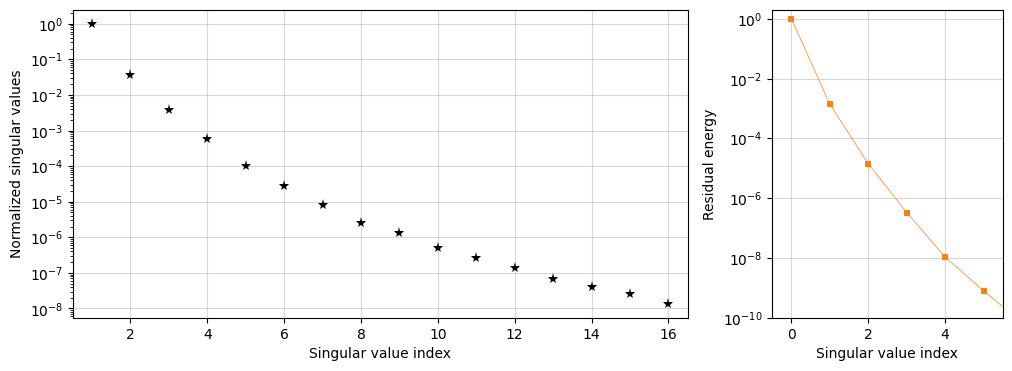

In [8]:
# plots of singular values and residual energy
fig, axs = plt.subplots(1, 2, figsize=(12, 4), width_ratios=[16, 6])

# left plot: singluar value decay
opinf.basis.svdval_decay(svdvals, threshold=[], ax=axs[0])
axs[0].grid(True, alpha=0.5)
axs[0].set_xlim(0.5, 16.5)

# right plot: residual energy (NOT in percent)
opinf.basis.residual_energy(svdvals, threshold=[], ax=axs[1])
axs[1].set_ylim(1e-10, 2)
axs[1].set_xlim(-0.5, 5.5)
axs[1].grid(True, alpha=0.5)

Here, we follow [2] and choose the reduced dimension `nRB = 5`. The singular values and residual energy depend on whether the finite element mass matrix was used during the method of snapshots. The residual energy for $r=5$ is very small, for both inner product matrices. A small residual energy means that the training snapshots can be approximated well in the chosen reduced space. However, a larger dimension also leads to a larger number of degrees of freedom in the OpInf learning problem, which makes overfitting more likely. In view of this, and because additional POD basis vectors are increasingly less important, it can be benefitial for classic OpInf to accept a larger residual energy to get a smaller reduced dimension. However, nested OpInf suffers less from these issues because the POD hierarchy is respected during construction. Choosing $r=5$ is thus perfectly fine.

In [9]:
nRB = 5
VR = VR[:, :nRB]
basis = opinf.basis.LinearBasis(entries=VR, weights=mass_matrix)

## Operator Inference

We need to learn a linear-cubic model. For each test function, we have $r + \frac{r(r-1)(r-2)}{6}$ degrees of freedom.

In [10]:
linear_operator = opinf.operators.AffineLinearOperator(coeffs=1)
cubic_operator = opinf.operators.CubicOperator()

for n in range(1, nRB+1):
    print(f"r = {n}: number of unknowns {linear_operator.operator_dimension(s=1, r=n, m=None) + cubic_operator.operator_dimension(r=n, m=None)}")

r = 1: number of unknowns 2
r = 2: number of unknowns 6
r = 3: number of unknowns 13
r = 4: number of unknowns 24
r = 5: number of unknowns 40


### Data preparation
We bring our snapshot training data into the form we need for OpInf. That means in particular:
- computing the projection onto the reduced space
- approximating the time derivative (here, with first order forward differences)

In [11]:
U_proj = np.zeros(n_para, dtype = object)
U_proj_short = np.zeros(n_para, dtype = object)
U_dot = np.zeros(n_para, dtype=object)

for i in range(n_para):

    # project training data onto reduced space
    U_proj[i] = basis.compress(U_train[i])

    # compute time derivative
    U_proj_short[i], U_dot[i] = opinf.ddt.fwd1(U_proj[i], dt=grid_t[1])

u0 = U_proj[0][:, 0]

### Helper functions

We define a couple of helper functions to streamline some of the in-between steps.

This first function evaluates for a given ROM the error the training snapshots at each training parameter. The error is evaluated in the full-order space:
$$\|\mathbf{x} - \mathbf{V} \widehat{\mathbf{x}}\|^2_{L^2(0, t_{\rm{tr}})} 
= \int_0^{t_{\rm{tr}}} \|\mathbf{x}(t) - \mathbf{V} \widehat{\mathbf{x}}(t)\|^2 dt
\approx \Delta t \sum_{k=1}^{K_{train}-1} \| \mathbf{x}(t_k) - \mathbf{V} \widehat{\mathbf{x}}(t_k) \|^2
+ \frac{\Delta t}{2} \| \mathbf{x}(0) - \mathbf{V} \widehat{\mathbf{x}}(0) \|^2
+ \frac{\Delta t}{2} \| \mathbf{x}(t_{\rm{tr}}) - \mathbf{V} \widehat{\mathbf{x}}(t_{\rm{tr}}) \|^2
$$
where $t_k = k \Delta t$ (equidistant time stepping) and $t_{\rm{tr}}$ is the end of the training time. The quadrature scheme is the trapezoid rule.

In [12]:
def train_error(model, indices=None):

    # initialization
    n_para = Xi_train.shape[0]
    training_error = np.zeros(n_para)

    # compute reduced solution
    for k in range(n_para):
        
        sol_rb = model.predict(parameter=Xi_train[k, 0], state0=u0, t=grid_t[:K_train])

        if sol_rb.shape[1] < K_train:
            # print("wrong dimension:", sol_rb.shape[1], K_train)
            training_error[k] = np.inf
        else:

            diff = sol_rb - U_proj[k]
            norm2 = (la.norm(diff, axis=0)**2) * grid_t[1]
            norm2[0] /= 2
            norm2[-1] /= 2
            norm_in_reduced_space = np.sqrt(np.sum(norm2))

            yolo = norm_in_reduced_space / transformer.scale_
            training_error[k] = np.sqrt(
                yolo**2 + error_projection_additive[k, nRB-1] ** 2
            )
            # warning: this call to error_projection_additive is prone to errors and won't work if indices are different than [*range(n+1)]

    return training_error

error_projection = np.zeros((n_para, nRB, K_train))
error_projection_additive = np.zeros((n_para, nRB))

for n in range(nRB):
    for i in range(n_para):
        proj = VR[:, :n+1].T @ mass_matrix @ U_train[i] # note: U_train is already transformed
        diff = VR[:, :n+1] @ proj - U_train[i]
        diff = transformer.inverse_transform(diff)

        error_projection[i, n, :] = np.array([diff[:,i].T @ mass_matrix @ diff[:,i] for i in range(diff.shape[1])]) # squared norm at each time step
        norm2 = error_projection[i, n, :] * grid_t[1]
        norm2[0] /= 2
        norm2[-1] /= 2
        error_projection_additive[i, n] = np.sum(norm2) # squared norm integrated over time

        error_projection[i, n, :] = np.sqrt(error_projection[i, n, :]) # norm at each time step
        error_projection_additive[i, n] = np.sqrt(error_projection_additive[i, n])

The next function chooses the regularization parameters for which we like the training error and the condition number of the learning problem best. Specifically, we choose those regularizaton parameters for which the condition number of the regularized OpInf learning problem is maximal but the maximum training error is below 100 * (1 + `tolerance`) percent of the minimimal training error we have observed throughout all candidate. regularization parameters. This means we accept a model with slightly larger training error than the minimally observed one in exchange for better conditioning of the learning problem. 

Note that `tolerance = 0` is an admissible choice in order to choose the model with the smallest training error.

In [13]:
# function for choosing best reconstruction error
def choose_regularization(training_error, condition_numbers, tolerance=0):
    # note: this function only works when optimizing over exactly 2 regularization parameters
    eval_fct = np.max

    global_minimum = np.min(eval_fct(training_error, axis = 2))
    min_cond = np.inf
    chosen_minimum = np.inf
    for i in range(training_error.shape[0]):
        for j in range(training_error.shape[1]):
            if eval_fct(training_error[i, j, :]) <= (1+tolerance) * global_minimum:
                if eval_fct(condition_numbers[i,j]) <= min_cond:
                    min_cond = eval_fct(condition_numbers[i,j])
                    i_A_chosen = i
                    i_H_chosen = j
                    chosen_minimum = eval_fct(training_error[i, j, :])

    return i_A_chosen, i_H_chosen, chosen_minimum

The next function is an implementation of Algorithm 2 in [2]. A paper dedicated to its analysis in its own right is in preparation.

In [ ]:
def iterativeUpdates(model, n_repeats):

    model._Ohat = np.zeros((nRB, 40)) # todo: put in actual number of unknowns
    model._extract_operators(Ohat=model._Ohat)

    for repeater in range(n_repeats):
        sol_iter = np.zeros(n_para, dtype=object)
        for k in range(n_para):
            sol_iter[k] = model.predict(parameter=Xi_test[index_test, 0], state0=u0, t=grid_t[:K_train-1])

            if sol_iter[k].shape[1] < K_train-1:
                return None

        U_iter = np.hstack([U_proj_short, sol_iter])
        R_iter = np.hstack([U_dot, U_dot])
        model.fit(parameters=np.hstack([Xi_train[:, 0], Xi_train[:, 0]]), states=U_iter, ddts=R_iter, initial_guess=model._Ohat)

    return model

### Classic Approach

First, we perform standard, regularized Operator Inference. We use a grid search over candidate regularization parameters for the linear and the cubic operators. We restrict our search to regularization parameters for cubic term that are at least as large as for the linear term.

In [15]:
n_test = 26
reg_min = -8
reg_max = -3
ratio_min = 0
ratio_max = 3
ratio_test = 16

# initialization
weights_linear = np.logspace(reg_min, reg_max, n_test)
ratio_cubic = np.logspace(ratio_min, ratio_max, ratio_test)
training_error = np.zeros((n_test, ratio_test, n_para))
condition_numbers = np.zeros((weights_linear.shape[0], ratio_cubic.shape[0]))
model_options = np.zeros((weights_linear.shape[0], ratio_cubic.shape[0]), dtype=object)

for i, reg_linear in enumerate(weights_linear):
    for j, ratio in enumerate(ratio_cubic):

        # how much regularization to apply to the cubic term
        reg_cubic = reg_linear * ratio

        # specify format of operators
        operators = [opinf.operators.AffinePolynomialOperator(coeffs=1, polynomial_order=1), 
                     opinf.operators.PolynomialOperator(polynomial_order=3)]

        # specify regularization scheme
        regularization = opinf.lstsq.TikhonovSolver.get_operator_regularizer(
                        operators = operators,
                        regularization_parameters = [reg_linear, reg_cubic], 
                        state_dimension=nRB)
        regularization = opinf.lstsq.TikhonovSolver(regularization)

        # set up model
        model = opinf.models.ParametricContinuousModel(
            operators = operators,
            solver = regularization
        )

        # solve OpInf least squares problem
        model.fit(parameters=Xi_train[:, 0], states=U_proj_short, ddts=U_dot)

        # compute condition number of regularized least squares problem
        condition_numbers[i, j] = regularization.regcond()

        # solve ROM for each training parameter
        training_error[i, j, :] = train_error(model=model)

        # remember model in case it gets selected
        model_options[i, j] = model

/oden/naretz/git/rom-operator-inference-Python3/src/opinf/models/mono/_nonparametric.py:1068: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(out.message, spintegrate.IntegrationWarning)


We use our helper function `choose_regularization` to determine which combination of regularization parameters (and corresponding ROM) has won.

In [16]:
tolerance = 0.1 # user setting

# identify indices of best model
i_A_chosen, i_H_chosen, error_chosen = choose_regularization(training_error=training_error, 
                                                             condition_numbers=condition_numbers, 
                                                             tolerance = tolerance)
model_opinf = model_options[i_A_chosen, i_H_chosen]
model = None # overwrite `model` variable so that we don't mistake it for the chosen `model_opinf`

print("The maximum training error of the chosen model is", error_chosen)

The maximum training error of the chosen model is 0.025545910036792935


To meet our scientific curiosity, we plot the training error for all considered parameters.

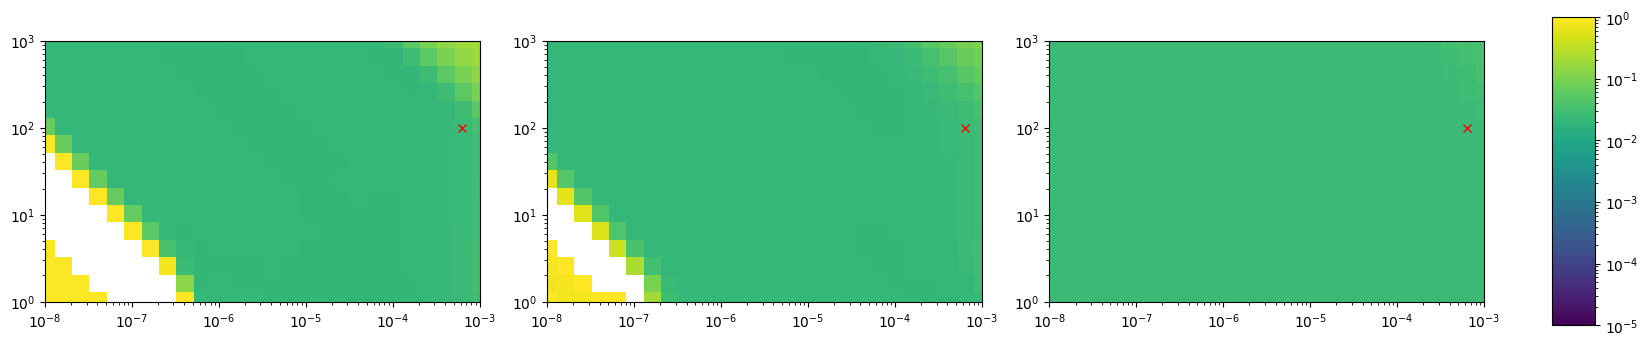

In [17]:
fig, axs = plt.subplots(1,n_para+1, sharex=False, sharey=False, figsize=(20, 4), width_ratios=[1, 1, 1, 0.1])

X, Y = np.meshgrid(weights_linear, ratio_cubic)

for i in range(n_para):
    cs = axs[i].pcolormesh(X, Y, training_error[:, :, i].T, norm = colors.LogNorm(), cmap=plt.colormaps["viridis"])
    cs.set_clim(vmin=1e-5, vmax=1e+0)

    axs[i].plot([weights_linear[i_A_chosen]], [ratio_cubic[i_H_chosen]], marker = "x", color="r")

    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].set_xlim(weights_linear[0], weights_linear[-1])
    axs[i].set_ylim(ratio_cubic[0], ratio_cubic[-1])
    axs[i].set_aspect("equal")
    
fig.colorbar(cs, cax=axs[n_para])

We can also look at what the ROM solution for any test parameter looks like in full-order space.

<>:19: SyntaxWarning: invalid escape sequence '\k'
<>:23: SyntaxWarning: invalid escape sequence '\k'
<>:27: SyntaxWarning: invalid escape sequence '\k'
<>:19: SyntaxWarning: invalid escape sequence '\k'
<>:23: SyntaxWarning: invalid escape sequence '\k'
<>:27: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_1287140/1615703703.py:19: SyntaxWarning: invalid escape sequence '\k'
  axs[0].set_title(f"full-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")
/tmp/ipykernel_1287140/1615703703.py:23: SyntaxWarning: invalid escape sequence '\k'
  axs[1].set_title(f"reduced-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")
/tmp/ipykernel_1287140/1615703703.py:27: SyntaxWarning: invalid escape sequence '\k'
  axs[2].set_title(f"difference, $\kappa ={Xi_test[index_test, 0]:.5f}$")


Text(0.5, 1.0, 'difference, $\\kappa =0.10000$')

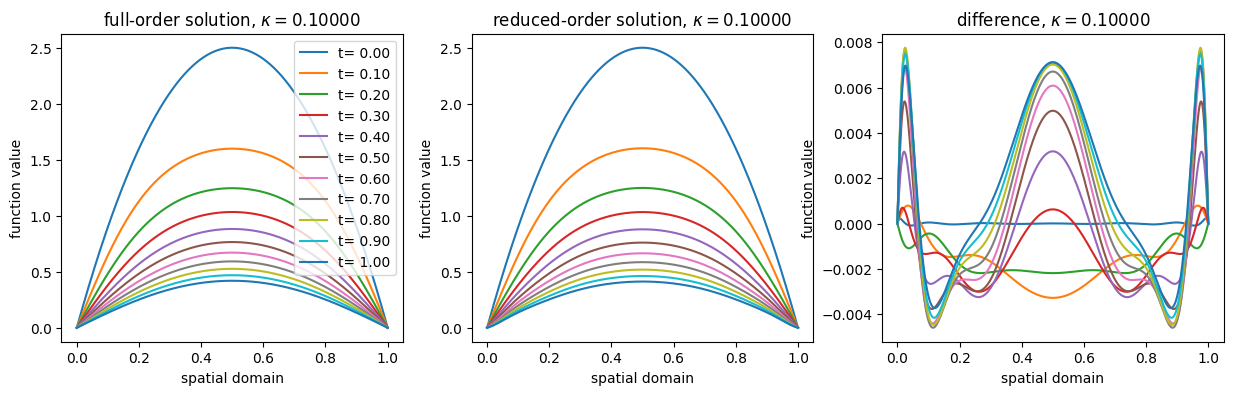

In [18]:
 # user input, choose between 0 and 200 (inclusive)
index_test = 200

sol = model_opinf.predict(parameter=Xi_test[index_test, 0], state0=u0, t=grid_t)
Sol = basis.decompress(sol)
Sol = transformer.inverse_transform(Sol)

# figure for how the parameter changes the FOM solution
fig, axs = plt.subplots(1, 3, figsize = (15, 4))

for k in range(0, K_test, 100):
    axs[0].plot(np.linspace(0, 1, nFE), U_para_test[index_test][:, k], label = f"t= {grid_t[k]:.2f}")
    axs[1].plot(np.linspace(0, 1, nFE), Sol[:, k], label = f"t= {grid_t[k]:.2f}")
    axs[2].plot(np.linspace(0, 1, nFE), U_para_test[index_test][:, k]-Sol[:, k], label = f"t= {grid_t[k]:.2f}")

axs[0].legend()
axs[0].set_xlabel("spatial domain")
axs[0].set_ylabel("function value")
axs[0].set_title(f"full-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")

axs[1].set_xlabel("spatial domain")
axs[1].set_ylabel("function value")
axs[1].set_title(f"reduced-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")

axs[2].set_xlabel("spatial domain")
axs[2].set_ylabel("function value")
axs[2].set_title(f"difference, $\kappa ={Xi_test[index_test, 0]:.5f}$")

Or we look at how the error changes as a function of time:

(-0.05, 1.05)

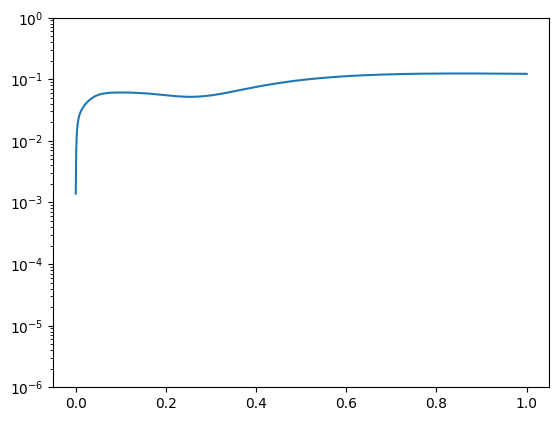

In [19]:
fig, ax = plt.subplots(1, 1)

ax.semilogy(grid_t, la.norm(U_para_test[index_test]-Sol, axis=0))

ax.set_ylim((1e-6, 1e+0))
ax.set_xlim((0-0.05, 1 + 0.05))

Whichever way we look at it, our ROM is really not doing particularly well, considering how large the chosen reduced dimension is and how small the residual error. If, instead, we choose a smaller reduced dimension (e.g., `nRB = 3`), then we actually get a smaller error than we are now observing for `nRB = 5`.

### Nested Operator Inference

## Comparison

## Note about iterative updates

In [71]:
n_test = 6
reg_min = -8
reg_max = -3
ratio_min = 0
ratio_max = 3
ratio_test = 4

# initialization
weights_linear = np.logspace(reg_min, reg_max, n_test)
ratio_cubic = np.logspace(ratio_min, ratio_max, ratio_test)
training_error = np.zeros((n_test, ratio_test, n_para))
condition_numbers = np.zeros((weights_linear.shape[0], ratio_cubic.shape[0]))
model_options = np.zeros((weights_linear.shape[0], ratio_cubic.shape[0]), dtype=object)

for i, reg_linear in enumerate(weights_linear):
    for j, ratio in enumerate(ratio_cubic):

        reg_cubic = reg_linear * ratio

        # specify format of operators
        operators = [opinf.operators.AffinePolynomialOperator(coeffs=1, polynomial_order=1), 
                        opinf.operators.PolynomialOperator(polynomial_order=3)]

        # specify regularization scheme
        regularization = opinf.lstsq.TikhonovSolver.get_operator_regularizer(
                        operators = operators,
                        regularization_parameters = [reg_linear, reg_cubic], 
                        state_dimension=nRB)
        regularization = opinf.lstsq.TikhonovSolver(regularization)

        # set up model
        model = opinf.models.ParametricContinuousModel(
            operators = operators,
            solver = regularization
        )

        model.fit(parameters=Xi_train[:, 0], states=U_proj_short, ddts=U_dot)
        model = iterativeUpdates(model, 500)

        # compute condition number of regularized least squares problem
        condition_numbers[i, j] = regularization.regcond()

        # solve ROM for each training parameter
        if model is None:
            training_error[i, j, :] = np.inf
        else:
            training_error[i, j, :] = train_error(model=model)

        # remember model in case it gets selected
        model_options[i, j] = model

In [75]:
tolerance = 0.1 # user setting

# identify indices of best model
i_A_chosen, i_H_chosen, error_chosen = choose_regularization(training_error=training_error, 
                                                             condition_numbers=condition_numbers, 
                                                             tolerance = tolerance)
model_iter = model_options[i_A_chosen, i_H_chosen]
model = None # overwrite `model` variable so that we don't mistake it for the chosen `model_opinf`

print("The maximum training error of the chosen model is", error_chosen)

The maximum training error of the chosen model is 0.037830282850839086


<>:19: SyntaxWarning: invalid escape sequence '\k'
<>:23: SyntaxWarning: invalid escape sequence '\k'
<>:27: SyntaxWarning: invalid escape sequence '\k'
<>:19: SyntaxWarning: invalid escape sequence '\k'
<>:23: SyntaxWarning: invalid escape sequence '\k'
<>:27: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_1287140/1870565397.py:19: SyntaxWarning: invalid escape sequence '\k'
  axs[0].set_title(f"full-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")
/tmp/ipykernel_1287140/1870565397.py:23: SyntaxWarning: invalid escape sequence '\k'
  axs[1].set_title(f"reduced-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")
/tmp/ipykernel_1287140/1870565397.py:27: SyntaxWarning: invalid escape sequence '\k'
  axs[2].set_title(f"difference, $\kappa ={Xi_test[index_test, 0]:.5f}$")


Text(0.5, 1.0, 'difference, $\\kappa =0.10000$')

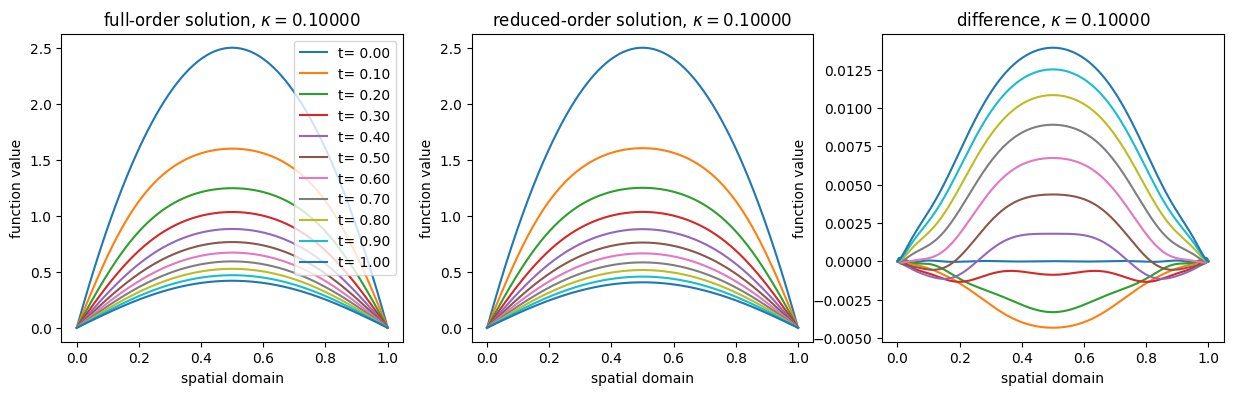

In [76]:
 # user input, choose between 0 and 200 (inclusive)
index_test = 200

sol = model_iter.predict(parameter=Xi_test[index_test, 0], state0=u0, t=grid_t)
Sol = basis.decompress(sol)
Sol = transformer.inverse_transform(Sol)

# figure for how the parameter changes the FOM solution
fig, axs = plt.subplots(1, 3, figsize = (15, 4))

for k in range(0, K_test, 100):
    axs[0].plot(np.linspace(0, 1, nFE), U_para_test[index_test][:, k], label = f"t= {grid_t[k]:.2f}")
    axs[1].plot(np.linspace(0, 1, nFE), Sol[:, k], label = f"t= {grid_t[k]:.2f}")
    axs[2].plot(np.linspace(0, 1, nFE), U_para_test[index_test][:, k]-Sol[:, k], label = f"t= {grid_t[k]:.2f}")

axs[0].legend()
axs[0].set_xlabel("spatial domain")
axs[0].set_ylabel("function value")
axs[0].set_title(f"full-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")

axs[1].set_xlabel("spatial domain")
axs[1].set_ylabel("function value")
axs[1].set_title(f"reduced-order solution, $\kappa ={Xi_test[index_test, 0]:.5f}$")

axs[2].set_xlabel("spatial domain")
axs[2].set_ylabel("function value")
axs[2].set_title(f"difference, $\kappa ={Xi_test[index_test, 0]:.5f}$")

(-0.05, 1.05)

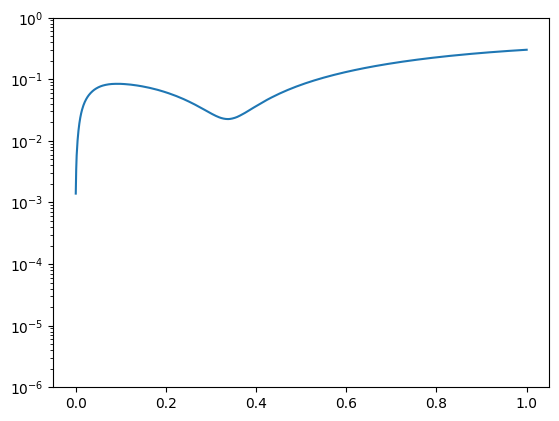

In [77]:
fig, ax = plt.subplots(1, 1)

ax.semilogy(grid_t, la.norm(U_para_test[index_test]-Sol, axis=0))

ax.set_ylim((1e-6, 1e+0))
ax.set_xlim((0-0.05, 1 + 0.05))

**Welcome back!** The error behaves as seen in my other implementation. So that's good news. Hopefully, nested OpInf will too.
I'm a bit worried about the iterative updates -- either I implemented them wrongly, or I misremember just how well / badly they are doing with standard OpInf. It's probably a good idea to get started with nested OpInf first, to distill things out more clearly.

## The End.